In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

#### 设置超参数

In [15]:
n_epochs = 5 
log_interval = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
size = 32 # 对输入图片进行处理，拉伸为32*32的图片
learn_rate = 0.03 # 学习率
momentum = 0.1  # 动量

#### 加载数据集

In [16]:
from torchvision.datasets import MNIST

transform = transforms.Compose(
    [transforms.Resize(size), transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))]) # 正则化处理，相当于z-score

trainset = MNIST(root = './', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = MNIST(root = './', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True, num_workers=2)

#### 设计LeNet-5网络
*咱也啥都不懂，代码CSDN上找的*

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=True) # C1层使用单通道，6深度的卷积核，卷积核大小为5
        self.max_pool_1 = nn.MaxPool2d(2)  # maxpooling从28降到14个像素点，故采用大小为2最大池化
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=True) # 第二次卷积
        self.max_pool_2 = nn.MaxPool2d(2) # 第二次maxpooling
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0, bias=F) #第三次卷积，得到120张大小为1的“图像”
        
        self.fc1 = nn.Linear(120,84) # 全连接层
        self.fc2 = nn.Linear(84,10) # 全连接层

    def forward(self, x):
        # print("0:"+ str(x.size())) # 输出tensor大小
        x = F.relu(self.conv1(x)) # 用激活函数处理卷积结果，激活函数结果再在下一步做maxpooling
        x = self.max_pool_1(x)
        # print("1:"+ str(x.size()))
        x = F.relu(self.conv2(x)) # 同上
        x = self.max_pool_2(x)
        # print("2:"+ str(x.size()))
        
        
        x = F.relu(self.conv3(x))
        # print("3:"+ str(x.size()))
        # x = F.dropout(x, training=self.training)
        x = x.view(-1, 120) # 把120张大小为1的图像当成一个长度为120的一维tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

#### 实例化神经网络

In [18]:
network = Net().to(DEVICE)
optimizer = optim.SGD(network.parameters(), lr = learn_rate, momentum=momentum) # 学习率，动量

#### 设置需要输出参数的存储变量

In [19]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)] #test_losses为横坐标，test_losses为纵坐标
test_acc = []

#### 定义训练参数

In [20]:
def train(epoch, device):
  network.train() # 调用上一步实例化对象network中的方法（该方法包内已经写好）
  for batch_idx, (data, target) in enumerate(trainloader): # 按batch_size为集合对象进行逐个处理
    data, target = data.to(device), target.to(device) # data是图片，target是标签，device是为了有GPU情况下使用GPU加速
    optimizer.zero_grad() # 开始进行BP之前将梯度设置为零，因为PyTorch会在随后的BP中累积梯度
    output = network(data) 
    loss = F.nll_loss(output, target) # 函数全称是negative log likelihood loss，下面博客有详细解释
    loss.backward() # 根据误差进行BP
    optimizer.step()
    if batch_idx % log_interval == 0: # 控制输出频率
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item()) # 记录并储存train loss
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))

#### 定义测试函数

In [21]:
def test(device):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1] # 找到概率最大的下标，为预测类别
      correct += pred.eq(target.data.view_as(pred)).sum() # x下面都是记录数据用于绘图，不再解释
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))
  test_acc.append(correct / len(testloader.dataset))

#### 训练模型，绘制图像

C:\Users\Admin\AppData\Local\Temp\ipykernel_31092\3532451503.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\Admin\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3040, Accuracy: 1146/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311926
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296865
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.299838
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.292975
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.290861
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.285784
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.273038
Train Epoch: 1 [13440/60000 (22%)]	Loss: 2.250086
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.244963
Train Epoch: 1 [17280/60000 (29%)]	Loss: 2.162446
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.025687
Train Epoch: 1 [21120/60000 (35%)]	Loss: 1.923427
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.614430
Train Epoch: 1 [24960/60000 (42%)]	Loss: 1.622141
Train Epoch: 1 [26880/60000 (45%)]	Loss: 1.391209
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.456099
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.338546
Train Epoch: 1 [32640/60000 (54%)]	Loss: 1.440631
Train Epoch: 1 [34560/60000 (58%)]	Loss: 1.128309
Trai

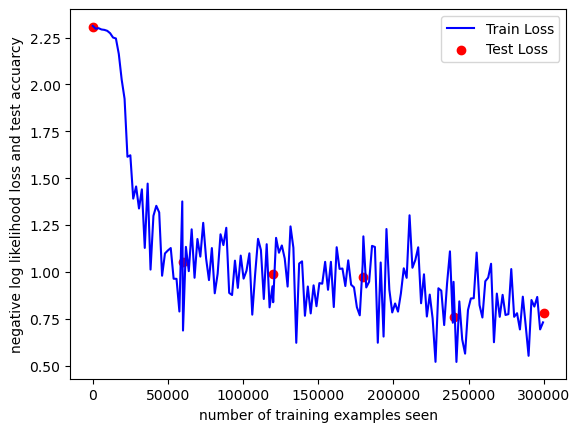

In [22]:
test(DEVICE)
for epoch in range(1, n_epochs + 1):
  train(epoch, DEVICE)
  test(DEVICE)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue') # train_losses变化曲线
plt.scatter(test_counter, test_losses, color='red') # test集loss散点图
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss and test accuarcy')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_31092\3532451503.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


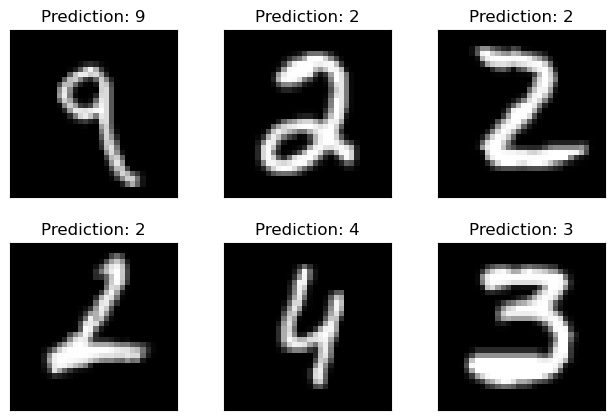

In [23]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
  example_data, example_targets = example_data.to(DEVICE), example_targets.to(DEVICE)
  output = network(example_data)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu().clone().numpy(), cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()
